Informations:
* Data collecting tool: **Atop**  
* Features extraction tool: **Atop**

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

1. Preprocessing

In [3]:
folder = os.path.join("..", "0_dataset", "accounting")
filenames = ['label_atop_mirai.csv', 'label_atop_disk_wipe.csv', 'label_atop_ransomware.csv',
                  'label_atop_resource_hijacking.csv', 'label_atop_end_point_dos.csv']

one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
# removed_fields = ['TIMESTAMP', 'PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}
technique_data_size = [0]

df = pd.DataFrame()
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------")
    print("file name:{0}".format(tmp_filename))
    print("-------------------------------------")
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename)

    # simple analysis
    labels = tmp_df['Label'].unique()
    print('label uniques: {0}'.format(labels))
    for j in labels:
        class_data_size = len(tmp_df[tmp_df['Label'] == j])
        # print('number of class-{0}: {1}'.format(j, class_data_size))
        if j == 0:
            technique_data_size[0] += class_data_size
        else:
            technique_data_size.append(class_data_size)
    # print("feature numbers: {0}".format(len(column_names)))
    # print(tmp_df.dtypes)
    # print(tmp_df.isnull().any())
    # print(tmp_df['RDDSK'].unique())
    df = df.append(tmp_df)

# delete useless features
for field in removed_fields:
    del df[field]

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')

output_filename = os.path.join(folder, 'preprocess_label_atop.csv')
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------
file name:label_atop_mirai.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_atop_disk_wipe.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_atop_ransomware.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_atop_resource_hijacking.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_atop_end_point_dos.csv
-------------------------------------
label uniques: [0 1]


2. Visualization (class number)

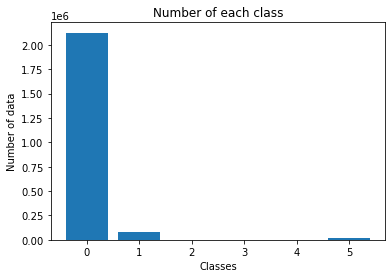

number of class-0: 2123993
number of class-1: 84100
number of class-2: 625
number of class-3: 875
number of class-4: 400
number of class-5: 20323


In [6]:
def bar_class_num(technique_data_size):
    labels = [i for i in range(len(technique_data_size))]
    class_num = np.arange(len(technique_data_size))
    plt.bar(class_num, technique_data_size)
    plt.xticks(class_num, labels)
    plt.xlabel("Classes")
    plt.ylabel("Number of data")
    plt.title("Number of each class")
    plt.show()

bar_class_num(technique_data_size)
for i in range(len(technique_data_size)):
    print('number of class-{0}: {1}'.format(i, technique_data_size[i]))

3. Data evaluation

4. Data balancing